In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys, time
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib
from sklearn import manifold
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [3]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2

In [4]:
import pywt

In [5]:
from imp import reload
import glob

In [6]:
# os.chdir('..')
os.chdir('/home/mike/ve/ml/')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics
from eegkaggle.models import neural
from keras.utils import np_utils
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise, GaussianDropout, Activation
from keras.models import Model, Sequential

/home/mike/ve/ml


Using TensorFlow backend.


In [7]:
print(matplotlib.style.available)
matplotlib.style.use('dark_background')
colors = ['k', 'r', 'g', 'b', 'm', 'y', 'c']


[u'seaborn-darkgrid', u'seaborn-notebook', u'seaborn-muted', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'classic', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [8]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

In [9]:
def scatter_heat(sorted_data, class_cut, rad=200, alpha=0.2):
    plt.scatter(sorted_data[:class_cut, 0], sorted_data[:class_cut, 1], edgecolor='none', c='b', s=3)
    plt.scatter(sorted_data[class_cut:, 0], sorted_data[class_cut:, 1], edgecolor='none', c='orange', s=rad, alpha=alpha )
    plt.scatter(sorted_data[class_cut:, 0], sorted_data[class_cut:, 1], edgecolor='none', c='r', s=5 )

In [ ]:
reload(dataio)
guess_path = '/run/media/mike/Elements/data/kaggle/melbourne/test_new/vec_logfourier_0343_238_0'
# guess_path = '/run/media/mike/Elements/data/kaggle/melbourne/test_new/vec_metric_pow_0283_468_0'
train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_logfourier_0314_411_0'
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_metric_pow_0275_890_0'
x_train, y_train = dataio.reload_with_labels(train_path)
x_guess, y_guess = dataio.reload_with_labels(guess_path)

In [24]:
files_train = pd.read_csv(train_path + '_name.csv', index_col=0) 
files_guess = pd.read_csv(guess_path + '_name.csv', index_col=0) 
print(x_train.shape, files_train.shape,  y_train.shape, files_guess.shape)

(6041, 16384) (6041, 1) (6041, 1) (1908, 1)


In [41]:
files_train['File'] = pd.Series([os.path.basename(nm) for nm in files_train['path']])
files_train['patient'] = pd.Series([int(nm[0]) for nm in files_train['File']])
files_train['label'] = pd.Series([int(nm[-5]) for nm in files_train['File']])
files_train.head()

,path,File,patient,label
0,/run/media/mike/Elements/data/kaggle/melbourne...,1_1000_0.mat,1,0
1,/run/media/mike/Elements/data/kaggle/melbourne...,1_1001_0.mat,1,0
2,/run/media/mike/Elements/data/kaggle/melbourne...,1_1002_0.mat,1,0
3,/run/media/mike/Elements/data/kaggle/melbourne...,1_1003_0.mat,1,0
4,/run/media/mike/Elements/data/kaggle/melbourne...,1_1004_0.mat,1,0


In [47]:
print(len(files_train[files_train['patient'] == 1]))
print(len(files_train[files_train['patient'] == 2]))
print(len(files_train[files_train['patient'] == 3]))

print(np.mean(files_train[files_train['patient'] == 1]['label'], axis=0))
print(np.mean(files_train[files_train['patient'] == 2]['label'], axis=0))
print(np.mean(files_train[files_train['patient'] == 3]['label'], axis=0))

1301
2346
2394
0.114527286703
0.0639386189258
0.062656641604


In [52]:
len(x_train[files_train['patient'] == 3])

/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


6041

In [75]:
def extract_patient_set(x_data, y_data, df, patient_num, col='patient'):
    mask = df[col] == patient_num
    select_df = df[mask]
    nb_records = sum(mask)
    vec_shape = x_data.shape[1:]
    new_x = np.zeros((nb_records,) + vec_shape )
    new_y = np.zeros((nb_records,) + y_data.shape[1:] )

    for i in range(nb_records):
        new_x[i] = x_data[select_df.index[i]]
        new_y[i] = y_data[select_df.index[i]]
    return new_x, new_y, select_df

x_train1, y_train1, df1 = extract_patient_set(x_train, y_train, files_train, 1)
x_train2, y_train2, df2 = extract_patient_set(x_train, y_train, files_train, 2)
x_train3, y_train3, df3 = extract_patient_set(x_train, y_train, files_train, 3)

print(x_train1.shape, y_train1.shape, df1.shape)

(1301, 16384) (1301, 1) (1301, 4)


In [120]:
def zdiff_by_channel(d0, d1, nchan=16):
    fullds = np.concatenate([d0, d1], axis=0)
    mean = np.mean(fullds, axis=0)
    mean0 = np.mean(d0, axis=0)
    mean1 = np.mean(d1, axis=0)
    std = np.std(fullds, axis=0)
    zdiff = (mean1-mean0)/std
    chans = []
    for i in range(nchan):
        chans.append(zdiff[i::nchan])
    return np.array(chans)


In [130]:
d0, d1, dt = dataio.separate_sets(x_train3, y_train3)
auc3 = auc_by_channel(d0, d1)

(16, 1024)

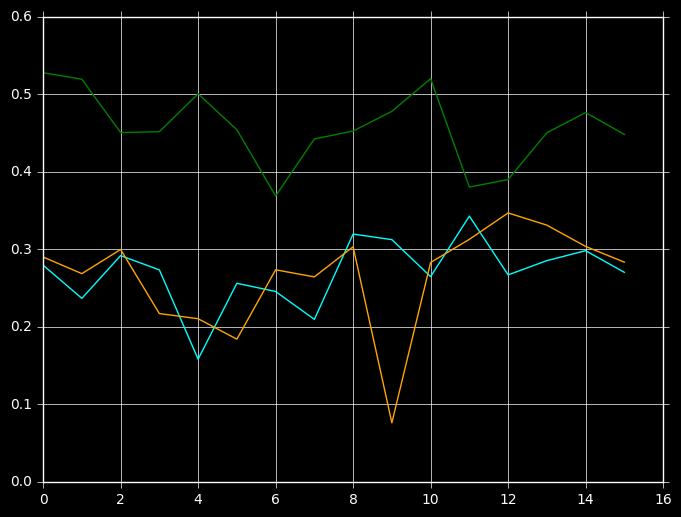

In [132]:

# plt.plot(auc[15])
plt.plot(np.std(auc1, axis=1), 'cyan')
plt.plot(np.std(auc2, axis=1), 'orange')
plt.plot(np.std(auc3, axis=1), 'green')
plt.savefig('auc_by_channel_by_patient.png')
auc.shape

In [133]:
mean0 = np.mean(d0, axis=0)
mean1 = np.mean(d1, axis=0)
std0 = np.std(d0, axis=0)
std1 = np.std(d1, axis=0)

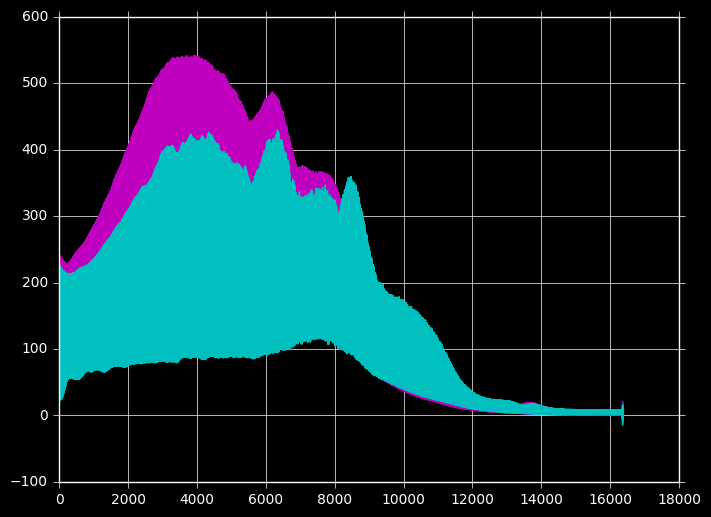

In [134]:
plt.plot(mean0, c='orange')
plt.plot(mean1, c='green')
plt.plot(mean0+std0, 'm')
plt.plot(mean0-std0, 'm')
plt.plot(mean1+std1, 'c')
plt.plot(mean1-std1, 'c')

(0, 1050)

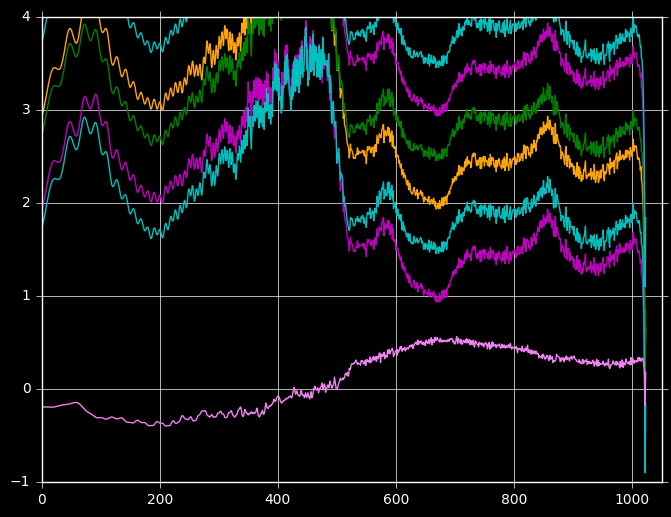

In [135]:
c=15
nch=16
normstd = (std0**2 + std1**2)**0.5
plt.plot(mean0[c::nch]/normstd[c::nch], c='orange')
plt.plot(mean1[c::nch]/normstd[c::nch], c='green')
plt.plot(mean0[c::nch]/normstd[c::nch] +1, 'm')
plt.plot(mean0[c::nch]/normstd[c::nch] -1, 'm')
plt.plot(mean1[c::nch]/normstd[c::nch] +1, 'c')
plt.plot(mean1[c::nch]/normstd[c::nch] -1, 'c')
plt.plot((mean1[c::nch] - mean0[c::nch])/normstd[c::nch], 'violet')
# plt.plot(auc[c], 'orange')
plt.ylim((-1,4))
plt.xlim((0,1050))
# plt.savefig('logft_train_ch{}.png'.format(c))

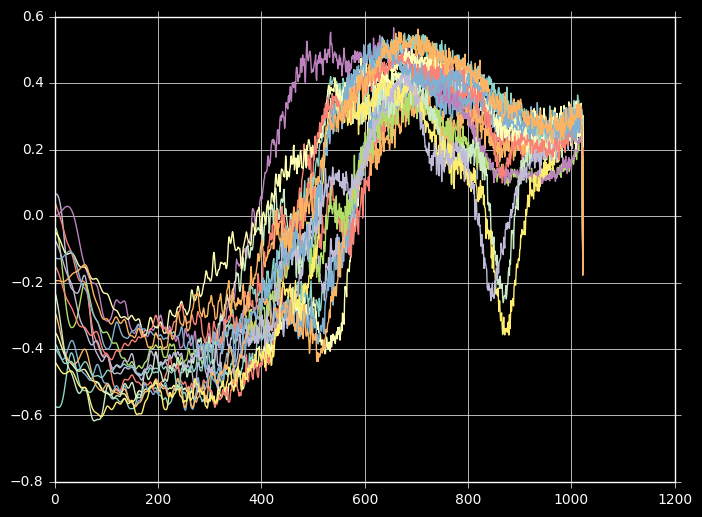

In [136]:
for c in range(16):
    plt.plot((mean1[c::nch] - mean0[c::nch])/normstd[c::nch])


In [163]:
X, Y = x_train3, y_train3
x_mean = np.mean(X, axis=0)
x_std = np.std(X, axis=0)
x_train_z = (X - x_mean) / x_std
y_train_z = Y
x_guess_z = (x_guess - x_mean) / x_std
d0_z = (d0 - x_mean) / x_std
d1_z = (d1 - x_mean) / x_std

In [164]:
x_train_s = np.concatenate([d0_z, d1_z], axis=0)
x_mean = np.mean(x_train_s, axis=0)
x_std = np.std(x_train_s, axis=0)
x_train_s = (x_train_s - x_mean) / x_std

In [165]:
x_train3.shape

(2394, 16384)

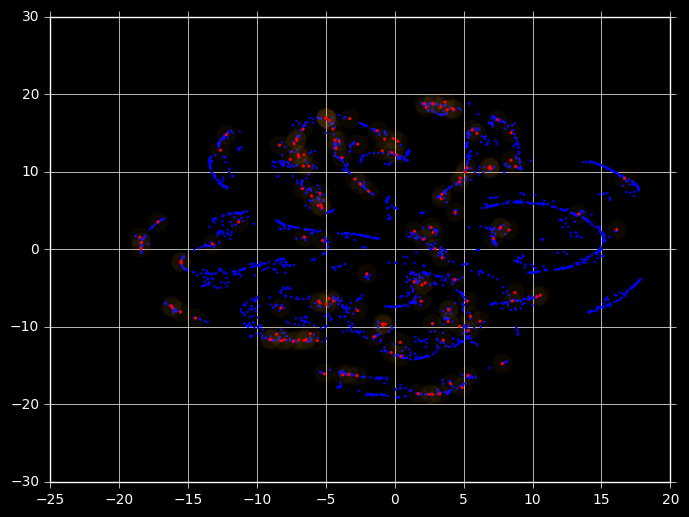

In [166]:
scatter_heat(sorted_data, len(d0), alpha=0.05)

In [185]:
reload(neural)
batch_size = 100
autoclasser = neural.SimpleAutoClasser(x_train.shape, batch_size=batch_size, latent_dim=8)
ae, enc, dec, classer = autoclasser.get_models()

DS shape: (6041, 16384)
('Batch Shape: ', (100, 16384))
Input Dims: 16384, input shape: (16384,), encoding dims: 8
('Sizes', [512, 44])


In [186]:
(x_train_, y_train_), (x_val2, y_val2) = dataio.subdiv_split_shuffle(x_train_z, y_train3, validation_split=0.505)
x_train_.reshape(x_train_.shape[0], x_train_.shape[1], 1)
# y_train2 = np_utils.to_categorical(np.asarray(y_train2, dtype=int), nb_classes=2)
y_val2 = np_utils.to_categorical(np.asarray(y_val2, dtype=int), nb_classes=2)
print(x_train_.shape, y_train_.shape, x_val2.shape, y_val2.shape)

val_cut:  75
(2244, 16384) (2244, 1) (150, 16384) (150, 2)


In [187]:
ae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 16384)         0                                            
____________________________________________________________________________________________________
dense_57 (Dense)                 (None, 512)           8389120     input_17[0][0]                   
____________________________________________________________________________________________________
gaussiannoise_17 (GaussianNoise) (None, 512)           0           dense_57[0][0]                   
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorma(None, 512)           1024        gaussiannoise_17[0][0]           
___________________________________________________________________________________________

In [189]:
ae.fit(x_train2, x_train2, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, x_val2))

Train on 2346 samples, validate on 150 samples
Epoch 1/3
2346/2346 [==============================] - 18s - loss: 836.5248 - val_loss: -0.6245
Epoch 2/3
2346/2346 [==============================] - 18s - loss: 606.6804 - val_loss: -0.8937
Epoch 3/3
2346/2346 [==============================] - 18s - loss: 390.2789 - val_loss: -0.9258


In [152]:
# classer.fit(x_train2, y_train2, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

In [ ]:
# CROSSTRAIN
nb_mega = 10
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    ae.fit(x_train2, x_train2, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, x_val2), shuffle=True)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=2, validation_data=(x_val2, y_val2), shuffle=True)

Mega-epoch 0 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [==============================] - 18s - loss: 251.4918 - val_loss: -0.7379
Train on 300 samples, validate on 150 samples
Epoch 1/2
300/300 [==============================] - 1s - loss: 5.8415 - acc: 0.4233 - val_loss: 0.7823 - val_acc: 0.4467
Epoch 2/2
300/300 [==============================] - 0s - loss: 5.8024 - acc: 0.5033 - val_loss: 0.7813 - val_acc: 0.4267
Mega-epoch 1 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [==============================] - 18s - loss: 170.0264 - val_loss: -0.5009
Train on 300 samples, validate on 150 samples
Epoch 1/2
300/300 [==============================] - 0s - loss: 5.7713 - acc: 0.4600 - val_loss: 0.7793 - val_acc: 0.4400
Epoch 2/2
300/300 [==============================] - 0s - loss: 5.7636 - acc: 0.4467 - val_loss: 0.7838 - val_acc: 0.4800
Mega-epoch 2 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [=========

In [ ]:
# Train just the classer
nb_mega = 10
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, y_val2))

In [156]:
encoded0 = autoclasser.encoder.predict(d0_z)
encoded1 = autoclasser.encoder.predict(d1_z)

In [157]:
encoded0.shape

(2244, 4)

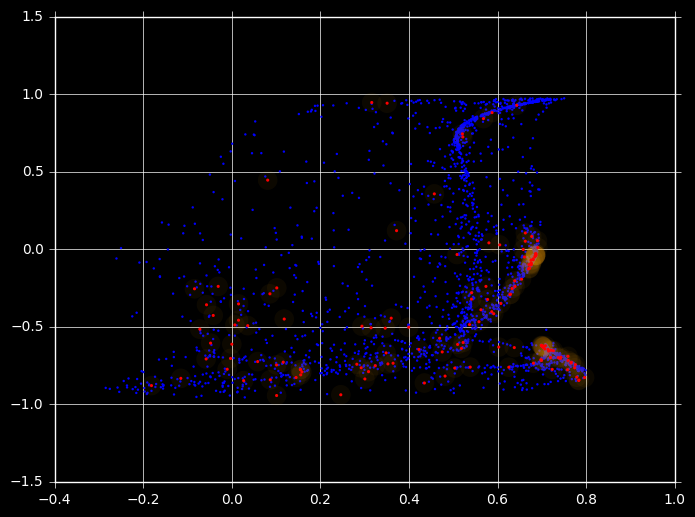

In [160]:
# plt.scatter(encoded0[:,0], encoded0[:,1])
# plt.scatter(encoded1[:,0], encoded1[:,1])
encoded = np.concatenate([encoded0, encoded1], axis=0)
scatter_heat(encoded[:,0:], len(d0_z), alpha=.05)

In [161]:
tsne = manifold.TSNE(random_state=1337)
sorted_data = tsne.fit_transform(encoded)

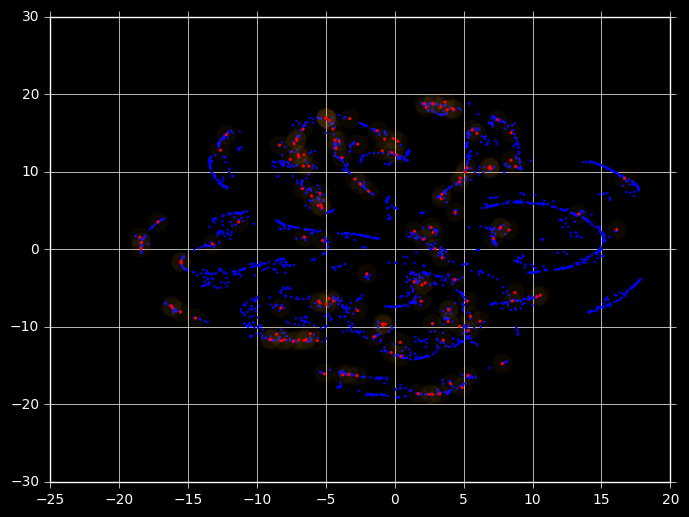

In [162]:
scatter_heat(sorted_data, len(d0_z), alpha=.05)

In [47]:
pred = classer.predict(x_guess_z)

In [48]:
np.mean(pred, axis=0)

array([ 0.51817632,  0.52593523], dtype=float32)

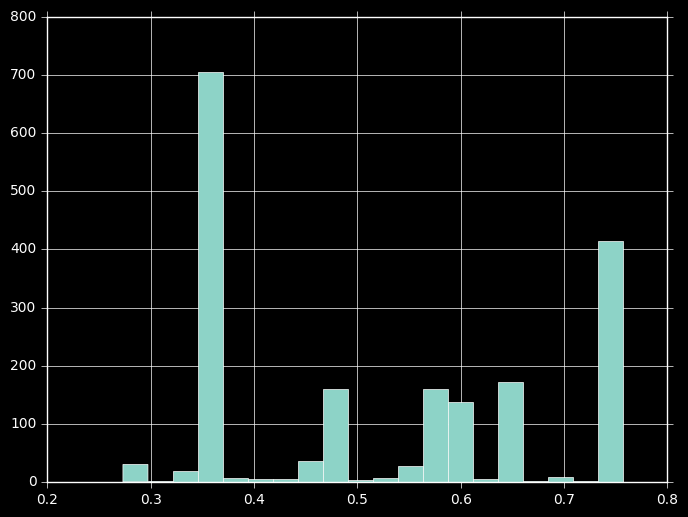

In [49]:
pd.Series(pred[:,0]).hist(bins=20)

In [50]:
pred_classes = pred > 0.5

In [51]:
np.mean(pred_classes, axis=0)

array([ 0.49056604,  0.28773585])

In [52]:
guess = pred_classes[:,0]

In [53]:
files2['Class'] = pd.Series(guess, dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [54]:
time_start = int(time.time())
time_str = str(time_start)[-7:-3] + '_' + str(time_start)[-3:]
files2.to_csv('./eegkaggle/guesses/new_AC_11_28_{}.csv'.format(time_str)) # fix this 

In [ ]:
nb_hidden = 255 # number of hidden nodes
nb_classes = 2 # ten digits, so ten output nodes (one-hot)
nb_epoch = 3 # number of epochs. 1 epoch is training once on the entire set of training samples

input_dim = x_train.shape[1] # 28x28 = 784
model = Sequential()
model.add(Dense(nb_hidden, activation='linear', input_dim=input_dim))
model.add(GaussianNoise(0.2))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(Dense(output_dim=nb_classes, activation='sigmoid')) # Here we use sigmoid because we wanna force the output to 0-1

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
nb_mega = 20
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    model.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

In [46]:
pred_classes = model.predict_classes(x_val2) # Let the model automatically determine the classes

AttributeError: 'Model' object has no attribute 'predict_classes'

In [ ]:
pred_classes

In [ ]:
valacc = np.mean(pred_classes == y_val2[:,1]) # Final accuracy on validation batch
print('Validation Accuracy: {}'.format(valacc))

In [ ]:
plt.plot(np.mean(x_guess_z, axis=0))

In [ ]:
guess = model.predict_classes(x_guess_z)

In [ ]:
np.mean(guess, axis=0)

In [ ]:
files2['Class'] = pd.Series(guess, dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [ ]:
time_start = int(time.time())
time_str = str(time_start)[-7:-3] + '_' + str(time_start)[-3:]
files2.to_csv('./eegkaggle/guesses/new_cnn_11_27_{}.csv'.format(time_str)) # fix this 